In [17]:
!c:\Users\rapha\anaconda3\python.exe -m pip install geopandas


In [18]:
import os
import scipy
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import geopandas as gpd
import statsmodels.api as sm
import ipywidgets as widgets
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from IPython.display import display, clear_output

In [19]:
import os
import shutil
import zipfile
import urllib.request

# URL do arquivo zip
url = "https://github.com/flaviovdf/fcd/raw/refs/heads/main/projeto/data_20251/real_data_fcd.zip"
caminho_zip = './real_data_fcd.zip'
caminho_destino = './data_fcd/'  # Pasta onde os arquivos serão extraídos

# Baixar o arquivo zip
urllib.request.urlretrieve(url, caminho_zip)

# Se já existe a pasta, apaga ela primeiro (para garantir substituição completa)
if os.path.exists(caminho_destino):
    shutil.rmtree(caminho_destino)

# Cria a pasta destino novamente
os.makedirs(caminho_destino, exist_ok=True)

# Descompacta mantendo estrutura
with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
    zip_ref.extractall(caminho_destino)

# Remove o zip
os.remove(caminho_zip)


In [20]:
caminho_destino

'./data_fcd/'

In [21]:
# Substituição de vírgulas por pontos nos arquivos CSV
arquivos_para_corrigir = [
    './data_fcd/indicadores/ibge_desemprego.csv',
    './data_fcd/indicadores/ibge_populacao.csv',
    './data_fcd/indicadores/ibge_pib.csv',
    './data_fcd/indicadores/ibge_sim.csv',
]

for arquivo in arquivos_para_corrigir:
    with open(arquivo, 'r', encoding='utf-8') as f:
        conteudo = f.read()

    conteudo = conteudo.replace(',', '.')

    with open(arquivo, 'w', encoding='utf-8') as f:
        f.write(conteudo)


In [22]:
indicadores = {}

for data in os.listdir("./data_fcd/indicadores/"):
    path = f"./data_fcd/indicadores/{data}"
    if os.path.isfile(path) and data.endswith('.csv'):
        nome_indicador = os.path.splitext(data)[0]
        df = pd.read_csv(path, sep=';')

        # Separar a coluna 'Municipio' em ID (6 dígitos) e Nome do município
        df[['ID', 'Nome_Mun']] = df['Municipio'].str.extract(r'(\d{6})\s+(.*)', expand=True)

        # Garantir que o ID seja string
        df['ID'] = df['ID'].astype(str)

        # Remover a coluna antiga 'Municipio' já que agora temos ID e Nome separados
        df.drop(columns=['Municipio'], inplace=True)

        # Salvar o dataframe processado
        indicadores[nome_indicador] = df

        print(f"Indicador: {nome_indicador} -> Colunas: {df.columns.tolist()[:5]}")

# Exemplo pra ver se está certo
print("Exemplo do indicador ibge_desemprego:")
print(indicadores['ibge_desemprego'].head())


Indicador: ibge_desemprego -> Colunas: ['Taxa_de_desemprego.', 'ID', 'Nome_Mun']
Indicador: ibge_pib -> Colunas: ['Produto_interno_bruto_(PIB).', 'ID', 'Nome_Mun']
Indicador: ibge_populacao -> Colunas: ['Populacao_residente', 'ID', 'Nome_Mun']
Indicador: ibge_sim -> Colunas: ['Obitos', 'ID', 'Nome_Mun']
Exemplo do indicador ibge_desemprego:
   Taxa_de_desemprego.      ID               Nome_Mun
0                 5.10  110001  ALTA FLORESTA D'OESTE
1                 4.64  110002              ARIQUEMES
2                 2.49  110003                 CABIXI
3                 5.87  110004                 CACOAL
4                 5.24  110005             CEREJEIRAS


In [39]:
indicadores['ibge_populacao']

,Populacao_residente,ID,Nome_Mun
0,24392,110001,ALTA FLORESTA D'OESTE
1,90353,110002,ARIQUEMES
2,6313,110003,CABIXI
3,78574,110004,CACOAL
4,17029,110005,CEREJEIRAS
...,...,...,...
5560,12548,522200,VIANOPOLIS
5561,7371,522205,VICENTINOPOLIS
5562,4735,522220,VILA BOA
5563,5145,522230,VILA PROPICIO


In [40]:
indicadores['ibge_sim']

,Obitos,ID,Nome_Mun
0,7,110001,ALTA FLORESTA D'OESTE
1,41,110002,ARIQUEMES
2,19,110004,CACOAL
3,9,110005,CEREJEIRAS
4,2,110006,COLORADO DO OESTE
...,...,...,...
3555,1,522190,VARJAO
3556,2,522200,VIANOPOLIS
3557,1,522205,VICENTINOPOLIS
3558,1,522220,VILA BOA


In [1]:
#In: 
# Função auxiliar para pegar código da UF
def sigla_to_cod(sigla):
    sigla = sigla.lower()
    uf_codigos = {
        'ro': '11', 'ac': '12', 'am': '13', 'rr': '14', 'pa': '15', 'ap': '16', 'to': '17',
        'ma': '21', 'pi': '22', 'ce': '23', 'rn': '24', 'pb': '25', 'pe': '26', 'al': '27', 'se': '28', 'ba': '29',
        'mg': '31', 'es': '32', 'rj': '33', 'sp': '35',
        'pr': '41', 'sc': '42', 'rs': '43',
        'ms': '50', 'mt': '51', 'go': '52', 'df': '53'
    }
    return uf_codigos[sigla]

# Dicionário com colunas e nomes bonitos
coluna_por_indicador = {
    'ibge_sim': 'Obitos',
    'ibge_populacao': 'Populacao_residente',
    'ibge_desemprego': 'Taxa_de_desemprego.',
    'ibge_pib': 'Produto_interno_bruto_(PIB).'
}

nomes_bonitos = {
    'ibge_pib': 'PIB',
    'ibge_sim': 'Óbitos',
    'ibge_populacao': 'População',
    'ibge_desemprego': 'Desemprego (%)'
}

siglas_estados = [
    'ac', 'al', 'am', 'ap', 'ba', 'ce', 'df', 'es', 'go',
    'ma', 'mg', 'ms', 'mt', 'pa', 'pb', 'pe', 'pi', 'pr',
    'rj', 'rn', 'ro', 'rr', 'rs', 'sc', 'se', 'sp', 'to'
]


In [2]:
nomes_bonitos

{'ibge_pib': 'PIB',
 'ibge_sim': 'Óbitos',
 'ibge_populacao': 'População',
 'ibge_desemprego': 'Desemprego (%)'}

In [41]:
siglas_estados

['ac',
 'al',
 'am',
 'ap',
 'ba',
 'ce',
 'df',
 'es',
 'go',
 'ma',
 'mg',
 'ms',
 'mt',
 'pa',
 'pb',
 'pe',
 'pi',
 'pr',
 'rj',
 'rn',
 'ro',
 'rr',
 'rs',
 'sc',
 'se',
 'sp',
 'to']

In [3]:
sigla_to_cod('mg')

'31'

In [5]:
#In: 
# Função para carregar o mapa do estado com indicador
def carregar_estado_mapa(sigla_estado, nome_indicador):
    coluna_indicador = coluna_por_indicador[nome_indicador]
    df_indicador = indicadores[nome_indicador]

    pasta_estado = f'../Projeto/data_fcd/dados_geograficos/{sigla_estado}_municipios/'
    arquivos_shp = [f for f in os.listdir(pasta_estado) if f.endswith('.shp')]
    if not arquivos_shp:
        print(f"Nenhum shapefile encontrado para {sigla_estado.upper()}")
        return None
    arquivo_shp = arquivos_shp[0]
    caminho_shp = os.path.join(pasta_estado, arquivo_shp)

    mapa = gpd.read_file(caminho_shp)
    mapa['cod6'] = mapa['CD_GEOCODM'].str[:6]

    df_indicador_filtered = df_indicador[df_indicador['ID'].isin(mapa['cod6'])]
    mapa_indicador = mapa.merge(df_indicador_filtered, left_on='cod6', right_on='ID', how='left')

    return mapa_indicador

# Função para plotar o estado
def plot_estado_indicador(sigla_estado, nome_indicador):
    mapa_indicador = carregar_estado_mapa(sigla_estado, nome_indicador)
    if mapa_indicador is None:
        return

    coluna_indicador = coluna_por_indicador[nome_indicador]

    plt.figure(figsize=(8, 6))
    mapa_indicador.plot(
        column=coluna_indicador,
        cmap='magma_r',
        legend=True,
        missing_kwds={"color": "lightgrey", "label": "Sem dado"},
        edgecolor='black',
        linewidth=0.3
    )
    plt.title(f"{sigla_estado.upper()} - {nomes_bonitos[nome_indicador]}")
    plt.axis('off')
    plt.show()

# Função para plotar o Brasil inteiro
brasil_mapa = None

def plot_brasil_indicador(nome_indicador):
    global brasil_mapa
    gdfs_estados = []
    coluna_indicador = coluna_por_indicador[nome_indicador]
    df_indicador = indicadores[nome_indicador]

    for sigla in tqdm(siglas_estados, desc="Carregando estados para mapa Brasil"):
        mapa_indicador = carregar_estado_mapa(sigla, nome_indicador)
        if mapa_indicador is not None:
            gdfs_estados.append(mapa_indicador)

    brasil_mapa = pd.concat(gdfs_estados, ignore_index=True)

    fig, ax = plt.subplots(figsize=(12, 10))
    brasil_mapa.plot(
        column=coluna_indicador,
        cmap='magma_r',
        legend=True,
        edgecolor="k",
        linewidth=0.1,
        missing_kwds={"color": "lightgrey", "label": "Sem dado"},
        ax=ax
    )

    ax.set_title(f"Brasil - {nomes_bonitos[nome_indicador]}")
    ax.axis('off')
    plt.show()



In [12]:
nomes_bonitos

{'ibge_pib': 'PIB',
 'ibge_sim': 'Óbitos',
 'ibge_populacao': 'População',
 'ibge_desemprego': 'Desemprego (%)'}

In [42]:
indicadores['ibge_pib']

,Produto_interno_bruto_(PIB).,ID,Nome_Mun
0,261949.6,110001,ALTA FLORESTA D'OESTE
1,1361647.2,110002,ARIQUEMES
2,69197.1,110003,CABIXI
3,1184416.7,110004,CACOAL
4,221800.7,110005,CEREJEIRAS
...,...,...,...
5560,171131.6,522200,VIANOPOLIS
5561,129492.7,522205,VICENTINOPOLIS
5562,75551.5,522220,VILA BOA
5563,92461.6,522230,VILA PROPICIO


<Figure size 800x600 with 0 Axes>

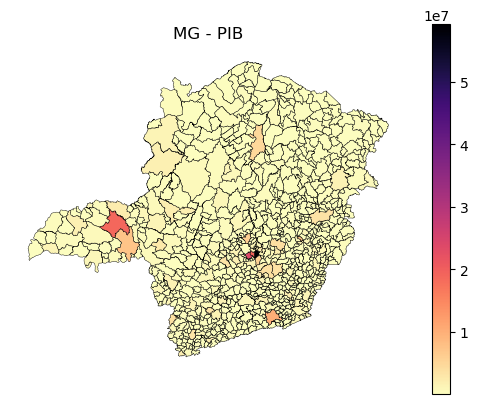

In [47]:

pibMG = carregar_estado_mapa("mg", "ibge_pib")
plotPibMG = plot_estado_indicador('mg', 'ibge_pib')

In [50]:
plot_brasil_indicador

<function __main__.plot_brasil_indicador(nome_indicador)>

Carregando estados para mapa Brasil: 100%|██████████| 27/27 [00:04<00:00,  6.22it/s]


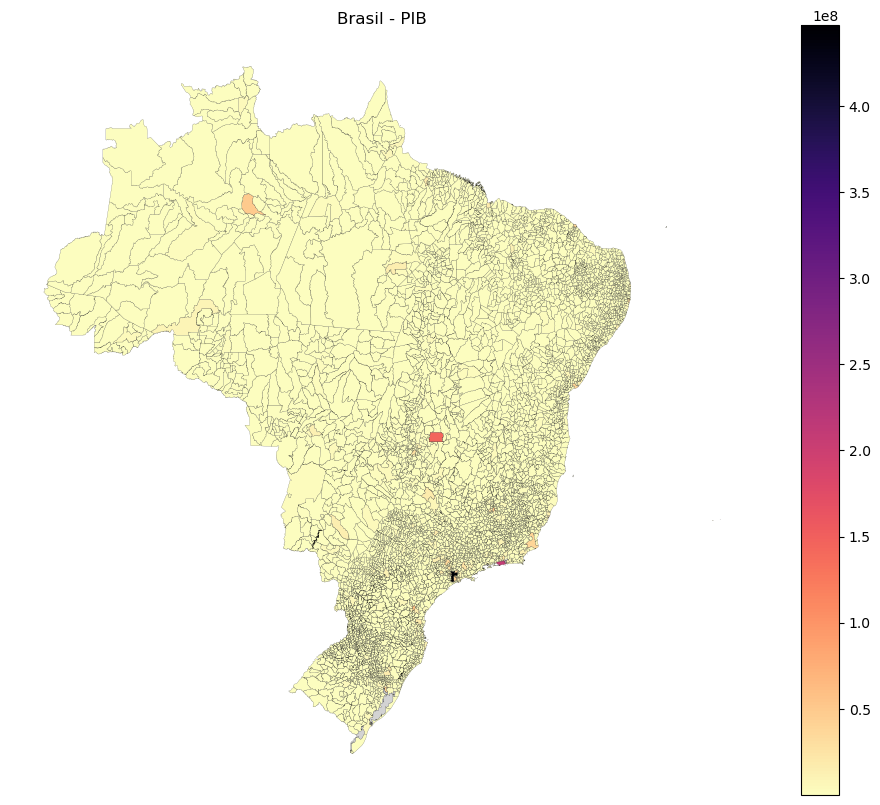

In [51]:
plot_brasil_indicador('ibge_pib')